In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import import_ipynb
from rotation import rotation_matrix, unit_vector, angle_between, x_rotation, y_rotation, z_rotation

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, EditedNearestNeighbours, AllKNN

import csv
from csv import reader
import pickle
from collections import Counter
from matplotlib import pyplot

importing Jupyter notebook from rotation.ipynb


In [4]:
NUM_FEATURES = 3
NUM_JOINTS = 20
NUM_FRAMES = 16
FILE_NAME = '../train.csv'
test_FILE_NAME = '../test.csv'

In [253]:
dtf = pd.read_csv(FILE_NAME, header = None)
dtf = dtf.sample(frac = 1)
X = dtf.iloc[:,:-1]
y = dtf.iloc[:,-1]

dtf_test = pd.read_csv(test_FILE_NAME, header = None)
dtf_test = dtf_test.sample(frac = 1)
X_test = dtf_test.iloc[:,:]
X_test_index = dtf_test.iloc[:,0]

In [12]:
def read_xyz(row):
    skeleton_data, label = read_skeleton(row)
    
    data = np.zeros((NUM_FRAMES, NUM_JOINTS, NUM_FEATURES))
    for m, i in enumerate(skeleton_data['frame_info']):
        for n, j in enumerate(i['joint_info']):
            feature_info = j['feature_info']
            data[m, n, :] = [feature_info['x'], feature_info['y'], feature_info['z']]

    data = data.transpose(2, 0, 1)
    return data, label

In [13]:
def read_skeleton(row):
    label = row[-1]
    #label = -1
    skeleton_data = {}
    skeleton_data['index'] = row[0]
    skeleton_data['num_frame'] = NUM_FRAMES
    skeleton_data['frame_info'] = []
    
    for frame in range(NUM_FRAMES):
        offset = NUM_JOINTS * NUM_FEATURES
        data_in_frame = row[frame*offset:(frame+1)*offset]
        frame_info = {}
        frame_info['num_joints'] = NUM_JOINTS
        frame_info['joint_info'] = []
        
        for feature in range(NUM_JOINTS):
            offset = NUM_FEATURES
            data_in_joint = data_in_frame[feature*offset:(feature+1)*offset]
            joint_info = {}
            joint_info['num_features'] = NUM_FEATURES
            joint_info['feature_info'] = {
                k: float(v)
                for k, v in zip(['x', 'y', 'z'], data_in_joint)
            }
            frame_info['joint_info'].append(joint_info)
                    
        skeleton_data['frame_info'].append(frame_info)
    return skeleton_data, label

In [6]:
#not in use
def normalisation(data):
    N, C, T, V, M = data.shape
    s = np.transpose(data, [0, 4, 2, 3, 1])
    zaxis=[0, 1]
    xaxis=[8, 4]
    
    print('sub the center joint #1 (spine joint in ntu and neck joint in kinetics)')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        main_body_center = skeleton[0][:, 1:2, :].copy()
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            mask = (person.sum(-1) != 0).reshape(T, V, 1)
            s[i_s, i_p] = (s[i_s, i_p] - main_body_center) * mask

    print('parallel the bone between hip(jpt 0) and spine(jpt 1) of the first person to the z axis')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        joint_bottom = skeleton[0, 0, zaxis[0]]
        joint_top = skeleton[0, 0, zaxis[1]]
        axis = np.cross(joint_top - joint_bottom, [0, 0, 1])
        angle = angle_between(joint_top - joint_bottom, [0, 0, 1])
        matrix_z = rotation_matrix(axis, angle)
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            for i_f, frame in enumerate(person):
                if frame.sum() == 0:
                    continue
                for i_j, joint in enumerate(frame):
                    s[i_s, i_p, i_f, i_j] = np.dot(matrix_z, joint)

    print('parallel the bone between right shoulder(jpt 8) and left shoulder(jpt 4) of the first person to the x axis')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        joint_rshoulder = skeleton[0, 0, xaxis[0]]
        joint_lshoulder = skeleton[0, 0, xaxis[1]]
        axis = np.cross(joint_rshoulder - joint_lshoulder, [1, 0, 0])
        angle = angle_between(joint_rshoulder - joint_lshoulder, [1, 0, 0])
        matrix_x = rotation_matrix(axis, angle)
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            for i_f, frame in enumerate(person):
                if frame.sum() == 0:
                    continue
                for i_j, joint in enumerate(frame):
                    s[i_s, i_p, i_f, i_j] = np.dot(matrix_x, joint)

    data = np.transpose(s, [0, 4, 2, 3, 1])
    return data
    

In [254]:
X_train = X.set_index(X.columns[0])
X_test = X_test.set_index(X_test.columns[0])

In [255]:
# minmax scaler
sss = model_selection.StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=None)
# for train_index, test_index in sss.split(X, y):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_test)

[[0.37264302 0.2914602  0.46314064 ... 0.53046655 0.54812111 0.56705443]
 [0.57377224 0.29604776 0.46197274 ... 0.57841233 0.5321645  0.5055455 ]
 [0.685416   0.20211776 0.43957764 ... 0.49207568 0.54085182 0.49279419]
 ...
 [0.42239267 0.29238302 0.46465961 ... 0.53342542 0.54070859 0.56477522]
 [0.50878875 0.2939409  0.46919514 ... 0.54224583 0.56218983 0.50908936]
 [0.51688505 0.29610731 0.47916658 ... 0.49351086 0.59887272 0.5199858 ]]


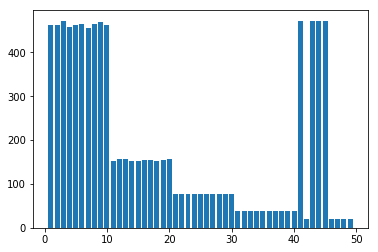

(9322, 961)
[[0.53030787 0.28423258 0.46979724 ... 0.52881306 0.54625698 0.56482759]
 [0.16043464 0.29563505 0.46780008 ... 0.50080392 0.55717611 0.63205852]
 [0.62682433 0.29516382 0.46352084 ... 0.71791451 0.50602032 0.37139795]
 ...
 [0.98916672 0.29482379 0.46412773 ... 0.5321243  0.55099078 0.56003597]
 [0.98872438 0.29349297 0.46390288 ... 0.52628373 0.54805448 0.56372496]
 [0.98756205 0.29647801 0.46255496 ... 0.52621719 0.54599427 0.56746236]]


In [256]:
##smote strategies for handling class imbalance

##upsample the minority class
smote = SMOTE(sampling_strategy='minority')
x_smote, y_smote = smote.fit_resample(X_train, y)

##determine how many minority class to increase
for i in range(2):
    x_smote, y_smote = smote.fit_resample(x_smote, y_smote)
    
##upsample all class to same amount
#x_smote, y_smote = SMOTE().fit_resample(X_train, y)

##Tomek
#x_smote, y_smote = SMOTETomek().fit_resample(X_train, y)

##Enn
#x_smote, y_smote = SMOTEENN().fit_resample(X_train, y)

##custom strategy, downsample first 10 class to ~200 data, upsample the rest to ~200 data.
# strategy = Counter(y)
# for key, val in strategy.items():
#     if key < 11:
#         strategy[key] = 200
        
#     else:
#         strategy[key] = val

# x_rus, y_rus = RandomUnderSampler(sampling_strategy=strategy).fit_resample(X_train, y)
# x_smote, y_smote = SMOTETomek(sampling_strategy='all').fit_resample(x_rus, y_rus)

pyplot.bar(Counter(y_smote).keys(), Counter(y_smote).values())
pyplot.show()

print(x_smote.shape)
print(x_smote)

In [257]:
#for train data after processing minmax/smote
fp = np.zeros((len(x_smote), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32) #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
for i, row in enumerate(x_smote):
    data, label = read_xyz(row)
    fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
np.save('train.npy', fp)

In [258]:
#for train label after processing minmax/smote
labels = []
for i, row in enumerate(y_smote.values):
    labels.append(row)
with open('label.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [ ]:
#for test data
fp = np.zeros((len(X_test), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32) #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
for i, row in enumerate(X_test):
    data, label = read_xyz(row)
    fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
np.save('test_minmax.npy', fp)

In [ ]:
#for test data, here lable is used as index
labels = []
for i, row in enumerate(X_test_index):
    labels.append(row-1)
with open('label_test.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [26]:
#for reading from original csv file
fp = np.zeros((len(dtf), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32)
    #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
with open(FILE_NAME, 'r') as f:
    csv_reader = reader(f)
    labels = []
    for i, row in enumerate(csv_reader):
        data, label = read_xyz(row)
        labels.append(int(float(label)))
        fp[i-5001, :, :, :, 0] = data
#fp = normalisation(fp)
np.save('train.npy', fp)
#np.save('test_data.npy', fp)

with open('label.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [22]:
unpickled_df = pd.read_pickle("label.pkl")
unpickled_df

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
